In [1]:
import os
import sys
import cv2
import json
from os.path import join

from PANDA import PANDA_IMAGE
import panda_utils as util
from ImgSplit import ImgSplit

import dftools
import pandatools
import pandas as pd
import seaborn as sns
import numpy as np

from pycocotools.coco import COCO

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
matplotlib.rcParams['interactive'] == True

True

In [132]:
def loadImg(imgpath):
    """
    :param imgpath: the path of image to load
    :return: loaded img object
    """
    print('filename:', imgpath)
    if not os.path.exists(imgpath):
        print('Can not find {}, please check local dataset!'.format(imgpath))
        return None
    img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    return img

In [13]:
# GT
#root_dir = 'C:/Users/KV_Zhao/Documents/DATASETS/PANDA/'
root_dir = '/Users/kv/workspace/detection_toolkits/datasets/preprocessing/PANDA-Toolkit'
split_dir = join(root_dir, 'split')
split_img_dir = join(split_dir, 'PANDA_IMAGE')
oracal_anno_path = join(root_dir, 'image_annos', 'person_bbox_train.json')
target_name = '04_Grant_Hall_IMG_04_01'
split_single_image_anno_path = join(split_dir, 'anno_split_train/single_images/{}.json'.format(target_name))
single_image_anno_path = join(root_dir, 'annoCOCO_fbox/scenes/04_Grant_Hall.json')

In [9]:
# DT
pred_target_name = target_name + '-CD1'
pred_root = '/Users/kv/workspace/detection_toolkits/datasets/preprocessing/PANDA-Toolkit'
#pred_root = 'C:/Users/KV_Zhao/Documents/Github/detection_toolkits/datasets/preprocessing/PANDA-Toolkit/'
pred_dir = join(pred_root, pred_target_name)
pred_anno_path = join(pred_dir, 'predictions.json')
det_res_path = join(pred_dir, 'detres.json')

/Users/kv/workspace/detection_toolkits/datasets/preprocessing/PANDA-Toolkit/04_Grant_Hall_IMG_04_01-CD1


In [14]:
fullGt = dftools.from_coco(single_image_anno_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [15]:
full_image_info = fullGt[fullGt.file_name == '04_Grant_Hall/IMG_04_01.jpg']

In [17]:
splitGt = dftools.from_coco(split_single_image_anno_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [11]:
Dt = dftools.from_coco(pred_anno_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [18]:
# split is not needed.
merged = pandatools.merge_coco_predictions(
    oracal_anno_path,
    split_single_image_anno_path,
    pred_anno_path)

Loading source annotation json file: /Users/kv/workspace/detection_toolkits/datasets/preprocessing/PANDA-Toolkit/image_annos/person_bbox_train.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [20]:
merged_output_path = '04_Grant_Hall_IMG_04_01-CD1/merged_annotations/merged.json'
json.dump(merged, open(merged_output_path, 'w'))

In [21]:
mergedDt = COCO(merged_output_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [22]:
mergedDt.loadImgs(mergedDt.getImgIds())

[{'height': 14238,
  'width': 25306,
  'file_name': '04_Grant_Hall/IMG_04_01.jpg',
  'id': 91}]

In [23]:
mergedAnns = mergedDt.loadAnns(mergedDt.getAnnIds())

In [24]:
len(mergedAnns)

210

In [25]:
len(full_image_info['bboxes'][0])

155

In [27]:
anndf = pd.DataFrame(mergedAnns)

In [28]:
anndf

,image_id,category_id,bbox,score,area,iscrowd,ignore,segmentation,id
0,91,2,"[21808, 6665, 463, 927]",0.97,429201,0,0,[],0
1,91,2,"[10805, 6528, 375, 758]",0.97,284250,0,0,[],1
2,91,2,"[24325, 6663, 544, 922]",0.97,501568,0,0,[],2
3,91,2,"[24810, 6596, 475, 990]",0.96,470250,0,0,[],3
4,91,2,"[21308, 6489, 335, 1007]",0.96,337345,0,0,[],4
...,...,...,...,...,...,...,...,...,...
205,91,2,"[6530, -10, 318, 737]",0.10,234366,0,0,[],205
206,91,2,"[7795, 8811, 299, 621]",0.10,185679,0,0,[],206
207,91,2,"[11315, 7367, 389, 847]",0.10,329483,0,0,[],207
208,91,2,"[15646, 1616, 142, 310]",0.10,44020,0,0,[],208


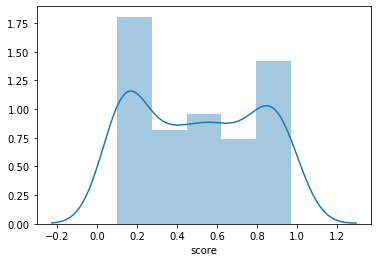

<Figure size 432x288 with 0 Axes>

In [29]:
sns.distplot(anndf.score)
plt.show()
plt.clf()

In [30]:
fullarea = (full_image_info.width * full_image_info.height)[0]

image_width = full_image_info.width[0]
image_height = full_image_info.height[0]

print(fullarea, image_width, image_height)

360306828 25306 14238


In [37]:
target_width = 2048 #image_width
target_height = int((image_height / image_width) * target_width)

aspect = (image_height / image_width)

print(target_width, target_height)

width_ratio , height_ratio = target_width / image_width, target_height / image_height
print(width_ratio, height_ratio)


2048 1152
0.0809294238520509 0.08091024020227561


In [38]:
anndf['area_ratio'] = anndf.apply(lambda x : x.area / fullarea, axis=1)
anndf['center'] = anndf.apply(lambda x : (x.bbox[0] + x.bbox[2] / 2, x.bbox[1] + x.bbox[3] / 2), axis=1)
anndf['width'] = anndf.apply(lambda x : x.bbox[2], axis=1)
anndf['height'] = anndf.apply(lambda x : x.bbox[3], axis=1)

In [39]:
anndf.center

0      (22039.5, 7128.5)
1      (10992.5, 6907.0)
2      (24597.0, 7124.0)
3      (25047.5, 7091.0)
4      (21475.5, 6992.5)
             ...        
205      (6689.0, 358.5)
206     (7944.5, 9121.5)
207    (11509.5, 7790.5)
208    (15717.0, 1771.0)
209     (7918.5, 2676.0)
Name: center, Length: 210, dtype: object

In [40]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)
             
def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [41]:
# DRAW THE BBOX HEATMAP
confThres = 0.2

conf_heatmap = np.zeros((target_height, target_width))
size_heatmap = np.zeros((target_height, target_width))
mapsize = np.sqrt(target_height * target_width)
for _, ann in anndf.iterrows():
    score = ann['score']
    if score < confThres:
        continue
    cx, cy = int(ann['center'][0] * width_ratio), int(ann['center'][1] * height_ratio)
    bw, bh = int(ann['bbox'][2] * width_ratio), int(ann['bbox'][3] * height_ratio)
    bsize = int(400 * np.sqrt(bw * bh) / mapsize)
    draw_umich_gaussian(conf_heatmap, [cx, cy], int(10 * score))
    draw_umich_gaussian(size_heatmap, [cx, cy], int(gaussian_radius([bh, bw])))

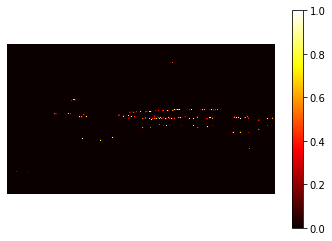

In [42]:
plt.imshow(conf_heatmap, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

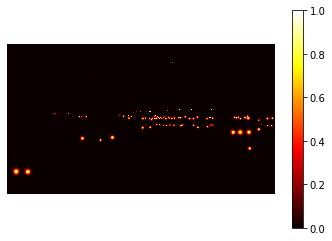

In [43]:
plt.imshow(size_heatmap, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

In [133]:
imgpath = join(pred_dir, 'Origin', '04_Grant_Hall/IMG_04_01.jpg')
img = Img = loadImg(imgpath)
scale = 0.5
resizeimg = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

filename: /Users/kv/workspace/detection_toolkits/datasets/preprocessing/PANDA-Toolkit/04_Grant_Hall_IMG_04_01-CD1/Origin/04_Grant_Hall/IMG_04_01.jpg


In [45]:
imgheight, imgwidth = resizeimg.shape[:2]
print(imgheight, imgwidth)

7119 12653


In [ ]:
plt.imshow(resizeimg[3000:4500, 4000:6000])
plt.show()

In [47]:
collision_map = np.zeros((target_height, target_width))
bbox_heatmap = np.zeros((target_height, target_width))
binary_bbox_heatmap = np.zeros((target_height, target_width))
for _, ann in anndf.iterrows():
    score = ann['score']
    if score < confThres:
        continue
    x, y, w, h = ann['bbox']
    x1 = int(x * width_ratio)
    x2 = int((x + w) * width_ratio)
    y1 = int(y * height_ratio)
    y2 = int((y + h) * height_ratio)
    bbox_heatmap[y1:y2, x1:x2] = score
    binary_bbox_heatmap[y1:y2, x1:x2] = 1
    collision_map[y1:y2, x1:x2] += score

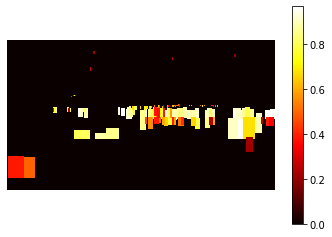

In [48]:
plt.imshow(bbox_heatmap, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

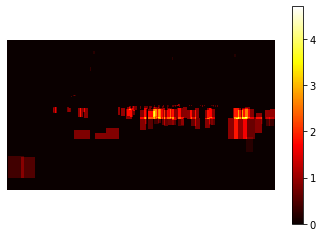

In [49]:
plt.imshow(collision_map, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

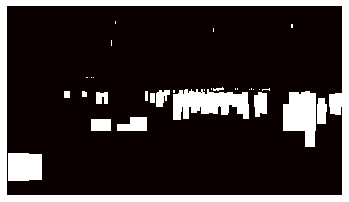

In [50]:
plt.imshow(binary_bbox_heatmap, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

In [52]:
patch_width = int(target_width / 8)
patch_height = int((target_width / 8) * aspect)
print(patch_width, patch_height)

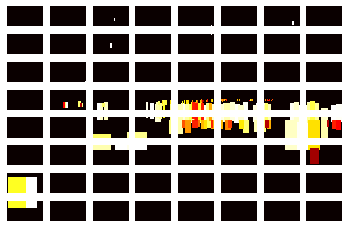

In [54]:
f, axarr = plt.subplots(8, 8)
for i in range(8):
    for j in range(8):
        axarr[i,j].axis('off')
        axarr[i,j].imshow(bbox_heatmap[i * patch_height : (i+1) * patch_height,
                                       j * patch_width : (j+1) * patch_width], cmap='hot')
plt.show()

In [55]:
anndf

,image_id,category_id,bbox,score,area,iscrowd,ignore,segmentation,id,area_ratio,center,width,height
0,91,2,"[21808, 6665, 463, 927]",0.97,429201,0,0,[],0,0.001191,"(22039.5, 7128.5)",463,927
1,91,2,"[10805, 6528, 375, 758]",0.97,284250,0,0,[],1,0.000789,"(10992.5, 6907.0)",375,758
2,91,2,"[24325, 6663, 544, 922]",0.97,501568,0,0,[],2,0.001392,"(24597.0, 7124.0)",544,922
3,91,2,"[24810, 6596, 475, 990]",0.96,470250,0,0,[],3,0.001305,"(25047.5, 7091.0)",475,990
4,91,2,"[21308, 6489, 335, 1007]",0.96,337345,0,0,[],4,0.000936,"(21475.5, 6992.5)",335,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,91,2,"[6530, -10, 318, 737]",0.10,234366,0,0,[],205,0.000650,"(6689.0, 358.5)",318,737
206,91,2,"[7795, 8811, 299, 621]",0.10,185679,0,0,[],206,0.000515,"(7944.5, 9121.5)",299,621
207,91,2,"[11315, 7367, 389, 847]",0.10,329483,0,0,[],207,0.000914,"(11509.5, 7790.5)",389,847
208,91,2,"[15646, 1616, 142, 310]",0.10,44020,0,0,[],208,0.000122,"(15717.0, 1771.0)",142,310


In [84]:
# flatten the anndf
anndf['bbox_x'] = anndf.apply(lambda x : x.bbox[0], axis=1)
anndf['bbox_y'] = anndf.apply(lambda x : x.bbox[1], axis=1)
anndf['bbox_w'] = anndf.apply(lambda x : x.bbox[2], axis=1)
anndf['bbox_h'] = anndf.apply(lambda x : x.bbox[3], axis=1)
anndf['cnt_x'] = anndf.apply(lambda x : x.center[0], axis=1)
anndf['cnt_y'] = anndf.apply(lambda x : x.center[1], axis=1)

In [85]:
anndf

,image_id,category_id,bbox,score,area,iscrowd,ignore,segmentation,id,area_ratio,center,width,height,bbox_x,bbox_y,bbox_w,bbox_h,cnt_x,cnt_y
0,91,2,"[21808, 6665, 463, 927]",0.97,429201,0,0,[],0,0.001191,"(22039.5, 7128.5)",463,927,21808,6665,463,927,22039.5,7128.5
1,91,2,"[10805, 6528, 375, 758]",0.97,284250,0,0,[],1,0.000789,"(10992.5, 6907.0)",375,758,10805,6528,375,758,10992.5,6907.0
2,91,2,"[24325, 6663, 544, 922]",0.97,501568,0,0,[],2,0.001392,"(24597.0, 7124.0)",544,922,24325,6663,544,922,24597.0,7124.0
3,91,2,"[24810, 6596, 475, 990]",0.96,470250,0,0,[],3,0.001305,"(25047.5, 7091.0)",475,990,24810,6596,475,990,25047.5,7091.0
4,91,2,"[21308, 6489, 335, 1007]",0.96,337345,0,0,[],4,0.000936,"(21475.5, 6992.5)",335,1007,21308,6489,335,1007,21475.5,6992.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,91,2,"[6530, -10, 318, 737]",0.10,234366,0,0,[],205,0.000650,"(6689.0, 358.5)",318,737,6530,-10,318,737,6689.0,358.5
206,91,2,"[7795, 8811, 299, 621]",0.10,185679,0,0,[],206,0.000515,"(7944.5, 9121.5)",299,621,7795,8811,299,621,7944.5,9121.5
207,91,2,"[11315, 7367, 389, 847]",0.10,329483,0,0,[],207,0.000914,"(11509.5, 7790.5)",389,847,11315,7367,389,847,11509.5,7790.5
208,91,2,"[15646, 1616, 142, 310]",0.10,44020,0,0,[],208,0.000122,"(15717.0, 1771.0)",142,310,15646,1616,142,310,15717.0,1771.0


In [56]:
full_image_info

,file_name,height,width,bboxes
0,04_Grant_Hall/IMG_04_01.jpg,14238,25306,"[[4563, 6429, 171, 493], [4327, 6467, 274, 458..."


In [202]:
# Uniform split
def uniform_split(
    annodf,
    image_width, image_height,
    subwidth=2048, subheight=1024, gap=100):
    left, up = 0, 0
    slidewidth = subwidth - gap
    slideheight = subheight - gap
    patch_id = 0
    patch_dict = []
    x, y = 0, 0
    while left < image_width:
        if left + subwidth >= image_width:
            left = max(image_width - subwidth, 0)
        up = 0
        while up < image_height:
            if up + subheight >= image_height:
                up = max(image_height - subheight, 0)
            right = min(left + subwidth, image_width - 1)
            down = min(up + subheight, image_height - 1)
            coordinates = left, up, right, down
            print(coordinates)
            patch = {
                'patch_id': patch_id,
                'x': x,
                'y': y,
                'left': left,
                'up': up,
                'right': right,
                'down': down,
            }
            # Find out all annotation within this patch
            # Center
            cnt_in_patch = anndf[(anndf.cnt_x > left) & (anndf.cnt_x < right)
                                & (anndf.cnt_y > up) & (anndf.cnt_y < down)]
            # BBox
            p1_ = (anndf.bbox_x > left) & (anndf.bbox_y > up) & (anndf.bbox_x < right) & (anndf.bbox_y < down)
            p2_ = (anndf.bbox_x + anndf.bbox_w > left) & (anndf.bbox_y > up) & (anndf.bbox_x + anndf.bbox_w < right) & (anndf.bbox_y < down)
            p3_ = (anndf.bbox_x > left) & (anndf.bbox_y + anndf.bbox_h > up) & (anndf.bbox_x < right) & (anndf.bbox_y + anndf.bbox_h < down)
            p4_ = (anndf.bbox_x + anndf.bbox_w < right) & \
                  (anndf.bbox_y + anndf.bbox_h < down) & \
                  (anndf.bbox_x + anndf.bbox_w > left) & \
                    (anndf.bbox_y + anndf.bbox_h > up)

            whole_box_in_patch = anndf[p1_ & p2_ & p3_ & p4_]
            upper_ = p1_ & p2_ & (~p3_) & (~p4_)
            lower_ = p3_ & p4_ & (~p1_) & (~p2_)
            left_ =  p3_ & p1_ & (~p2_) & (~p4_)
            right_ = p2_ & p4_ & (~p1_) & (~p3_)
            
            # BBox types
            upper_box_in_patch = anndf[upper_]
            lower_box_in_patch = anndf[lower_]
            left_box_in_patch = anndf[left_]
            right_box_in_patch = anndf[right_]
            
            # TODO: Also append annotation ids
            patch.update({
                'num_cnt': len(cnt_in_patch),
                'num_whole_box': len(whole_box_in_patch),
                'num_upper_box': len(upper_box_in_patch),
                'num_lower_box': len(lower_box_in_patch),
                'num_left_box': len(left_box_in_patch),
                'num_right_box': len(right_box_in_patch),
            })
            
            if patch_id in [10, 11, 17, 18, 30, 31]:
                #plt.imshow(img[up:down, left:right])
                #plt.show()
                print('Patch id:', patch_id, 'with centers', len(cnt_in_patch), ', whole bboxes', len(whole_box_in_patch))
                print('upper box', len(upper_box_in_patch), ', lower bbox', len(lower_box_in_patch))
            
            # Update
            patch_dict.append(patch)
            patch_id += 1
            if up + subheight >= image_height:
                y = 0
                break
            else:
                up = up + slideheight
                y += 1
        if left + subwidth >= image_width:
            x = 0
            break
        else:
            left = left + slidewidth
            x += 1
            
    print('#of patches:', patch_id + 1)
    patch = pd.DataFrame(patch_dict)
    # build the relation with neighbors
    return patch

In [203]:
subimage_width = image_width // 6
subimage_height = int(subimage_width * (image_height / image_width))
print(subimage_width, subimage_height, subimage_width / image_width, subimage_height / image_height)
patchdf = uniform_split(anndf, image_width, image_height, subimage_width, subimage_height)

4217 2372 0.16664032245317317 0.16659643208315775
(0, 0, 4217, 2372)
(0, 2272, 4217, 4644)
(0, 4544, 4217, 6916)
(0, 6816, 4217, 9188)
(0, 9088, 4217, 11460)
(0, 11360, 4217, 13732)
(0, 11866, 4217, 14237)
(4117, 0, 8334, 2372)
(4117, 2272, 8334, 4644)
(4117, 4544, 8334, 6916)
(4117, 6816, 8334, 9188)
Patch id: 10 with centers 5 , whole bboxes 0
upper box 3 , lower bbox 10
(4117, 9088, 8334, 11460)
Patch id: 11 with centers 3 , whole bboxes 1
upper box 0 , lower bbox 3
(4117, 11360, 8334, 13732)
(4117, 11866, 8334, 14237)
(8234, 0, 12451, 2372)
(8234, 2272, 12451, 4644)
(8234, 4544, 12451, 6916)
(8234, 6816, 12451, 9188)
Patch id: 17 with centers 8 , whole bboxes 1
upper box 2 , lower bbox 6
(8234, 9088, 12451, 11460)
Patch id: 18 with centers 2 , whole bboxes 0
upper box 0 , lower bbox 2
(8234, 11360, 12451, 13732)
(8234, 11866, 12451, 14237)
(12351, 0, 16568, 2372)
(12351, 2272, 16568, 4644)
(12351, 4544, 16568, 6916)
(12351, 6816, 16568, 9188)
(12351, 9088, 16568, 11460)
(12351, 113

In [275]:
patchdf['merged'] = 0
merged_id = 1
for _id, r in patchdf.sort_values('num_whole_box', ascending=False).iterrows():
    print('patch_id', r.patch_id)
    if r.num_whole_box == 0:
        break
    print('merged r', r.merged)
    if r.merged != 0:
        current_id = r.merged
        print('Get id from exising', current_id)
    else:
        patchdf.loc[_id]['merged'] = merged_id
        current_id = merged_id
        print('Get id from new', current_id)
        merged_id += 1
    nup = r.num_upper_box
    ndown = r.num_lower_box
    nr = r.num_right_box
    nl = r.num_left_box
    if sum([nup, ndown, nr, nl]) == 0:
        continue
    print(_id)
    direction = {
        nup: (0, +1),
        ndown: (0, -1),
        nr: (-1, 0),
        nl: (+1, 0),
    }
    print(r.x, r.y)
    for case in [nup, nlow, nr, nl]:
        if case == 0:
            continue
        dir_ = direction[case]
        new_x, new_y = r.x + dir_[0], r.y + dir_[1]
        print(new_x, new_y)
        if(new_x < 0 or new_y < 0):
            continue
        neighbor = patchdf[(patchdf.x == new_x) & (patchdf.y == new_y)].index.values[0]
        patchdf.loc[neighbor]['merged'] = current_id
        print('assign', current_id, 'to', new_x, new_y)
        
    

patch_id 23
merged r 0
Get id from new 1
23
3 2
3 3
assign 1 to 3 3
patch_id 30
merged r 0
Get id from new 2
30
4 2
4 3
assign 2 to 4 3
patch_id 24
merged r 0
Get id from new 3
24
3 3
4 3
assign 3 to 4 3
patch_id 9
merged r 0
Get id from new 4
9
1 2
1 3
assign 4 to 1 3
0 2
assign 4 to 0 2
patch_id 31
merged r 0
Get id from new 5
31
4 3
3 3
assign 5 to 3 3
patch_id 35
merged r 0
Get id from new 6
patch_id 45
merged r 0
Get id from new 7
45
6 3
6 4
assign 7 to 6 4
patch_id 42
merged r 0
Get id from new 8
patch_id 44
merged r 0
Get id from new 9
44
6 2
6 3
assign 9 to 6 3
patch_id 7
merged r 0
Get id from new 10
7
1 0
1 -1
patch_id 38
merged r 0
Get id from new 11
38
5 3
5 4
assign 11 to 5 4
6 3
assign 11 to 6 3
patch_id 37
merged r 0
Get id from new 12
37
5 2
5 3
assign 12 to 5 3
patch_id 21
merged r 0
Get id from new 13
21
3 0
4 0
assign 13 to 4 0
patch_id 16
merged r 0
Get id from new 14
16
2 2
2 3
assign 14 to 2 3
patch_id 28
merged r 0
Get id from new 15
28
4 0
3 0
assign 15 to 3 0
3

In [276]:
patchdf

,patch_id,x,y,left,up,right,down,num_cnt,num_whole_box,num_upper_box,num_lower_box,num_left_box,num_right_box,merged
0,0,0,0,0,0,4217,2372,0,0,0,0,0,0,0
1,1,0,1,0,2272,4217,4644,0,0,0,0,0,0,0
2,2,0,2,0,4544,4217,6916,1,0,0,0,1,0,4
3,3,0,3,0,6816,4217,9188,0,0,0,0,0,0,0
4,4,0,4,0,9088,4217,11460,2,2,3,0,0,0,18
5,5,0,5,0,11360,4217,13732,3,0,0,3,0,0,18
6,6,0,6,0,11866,4217,14237,3,0,0,3,0,0,0
7,7,1,0,4117,0,8334,2372,7,6,1,1,0,0,10
8,8,1,1,4117,2272,8334,4644,3,3,0,0,0,0,16
9,9,1,2,4117,4544,8334,6916,21,17,6,0,0,1,4
